## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2021-06-13 22:49:03--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.003s  

2021-06-13 22:49:03 (39.7 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
text = ''.join(text).lower()
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
idx_to_token = {idx: token for idx, token in enumerate(tokens)}
assert len(token_to_idx) == len(idx_to_token)

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [6]:
def to_matrix(pieces, max_len=None):
  if max_len == None: 
    max_len = max(map(len, pieces))

  text_ix = np.zeros((len(pieces), max_len), dtype='int32')
  for i in range(len(pieces)): 
    line_ix = [token_to_idx[c] for c in pieces[i]]
    text_ix[i, :len(line_ix)] = line_ix
  return text_ix

In [7]:
import torch, torch.nn as nn
import torch.nn.functional as F
device = 'cuda'

In [8]:

class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True).to(device)

In [9]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [10]:
def get_shifts(num, start=0, piece_len=100, step=1):
  res = []
  for i in range(num): 
    if start + piece_len >= len(text) - 1:
      print("ooops")
      break
    res.append(text[start:start+piece_len])
    start += step
  return res

In [16]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from random import sample
from tqdm import trange

char_rnn = CharRNNCell().to(device)
opt = torch.optim.Adam(char_rnn.parameters())

In [17]:
def training_loop(rnn, opt, epochs=30):
  loss_history = []
  for epoch in range(epochs):
    loss_this_epoch = 0
    for batch_idx in trange(NUM_BATCHES):
      pieces = get_shifts(BATCH_SIZE, start=batch_idx * BATCH_SIZE, piece_len=MAX_LEN)
      samples = torch.tensor(to_matrix(pieces), dtype=torch.int64).to(device)
      batch_ix = samples[:, :-1]
      opt.zero_grad()
      logp_seq = rnn_loop(rnn, batch_ix)
      actual_next_tokens = samples[:, 1:]
      predictions_logp = logp_seq
      logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])
      loss = -logp_next.mean()
      #loss_history.append(loss.detach().cpu().numpy())
      loss_this_epoch += loss.detach().cpu().numpy()
      loss.backward()
      opt.step()
    loss_this_epoch /= NUM_BATCHES
    print('Training epoch: {} Loss: {}'.format(epoch, loss_this_epoch))
    loss_history.append(loss_this_epoch)
    clear_output(True)
    plt.plot(loss_history,label='loss')
    plt.legend()
    plt.show()

  return loss_history

In [18]:
MAX_LEN = 120
BATCH_SIZE = 200
NUM_BATCHES = (len(text) - MAX_LEN) // BATCH_SIZE

In [19]:
from tqdm import tqdm
tqdm._instances.clear()

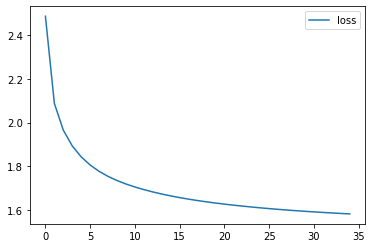

In [20]:
loss_history = training_loop(char_rnn, opt, 35)

In [21]:
MAX_LEN = 100
def generate_sample(char_rnn, seed_phrase='hello', max_length=MAX_LEN, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = char_rnn.initial_state(batch_size=1)
  
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        # print(x_sequence[:, -1].shape, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)
  
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.cpu().numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])

In [23]:
# An example of generated text.
print(generate_sample(char_rnn, seed_phrase='love', max_length=500, temperature=0.8))

love?
  for thered thy goods the from thy fair bat which all thy glory all the blow;
  my foust i clo'd better be condast that in thy eyes as thee, see chand art a the better fall the love;
  thee,
  and suspeds be i all thou dost the trunkine!
  in my bater's proud how my praaty is thy greated,
    hour die,
  and may, i  thine,
  who doth lovery wilt creater's for on thy love is deswith hyous forgets have belings hath paron not heers wite!
  on thee, to to have five heart, who all they slave f


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [24]:
device = 'cuda'

In [25]:
class LSTMCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.LSTMCell(embedding_size, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        h_next = self.rnn_update(x_emb, h_prev)
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next[0])
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return [torch.zeros(batch_size, self.num_units, requires_grad=True).to(device) for i in range(2)]

In [26]:
lstm_rnn = LSTMCell().to(device)
lstm_opt = torch.optim.Adam(lstm_rnn.parameters())

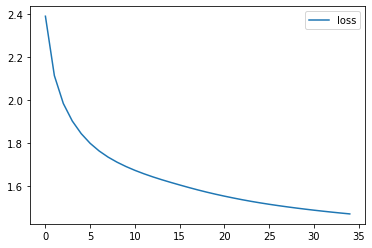

In [28]:
loss_history_lstm = training_loop(lstm_rnn, lstm_opt, 35)

In [36]:
print(generate_sample(lstm_rnn, seed_phrase='love', max_length=500, temperature=1))

love she tencack
  the suration it, when do me their ginst make agatt is is ronebuless,
  fith your polowing just on my as false sways,-sman to is all:
    and foul fairs did forget to tweep, this to bespoin's end
  whereight swarly fool mor'trow thee, me,
  since should now which is holcods thee mose,--:
  my vandest to i and hollel your hipps alavel
  a joy took same as hor, be thy showing mack,
  not the love reath make my love not so that eye;
  for this see hath withanty shorken by deteraca


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [43]:
print("\n***\n")
print(generate_sample(lstm_rnn, seed_phrase='love', max_length=500, temperature=0.1))
print("\n***\n")
print(generate_sample(lstm_rnn, seed_phrase='love', max_length=500, temperature=0.2))
print("\n***\n")
print(generate_sample(lstm_rnn, seed_phrase='love', max_length=500, temperature=0.5))
print("\n***\n")
print(generate_sample(lstm_rnn, seed_phrase='love', max_length=500, temperature=1))
print("\n***\n")
print(generate_sample(lstm_rnn, seed_phrase='love', max_length=500, temperature=2))


***

love thee the strange thee thee thee the strange thee thee thee to thee,
  the world thee the world thee thee the confound thee thee,
    then the world that the world thee the sunself the world thee i am my self thee the strange thee thee i do my self thee thee to thee thee thee,
    and the world the world thee the world that thee the from thee thee to thee.

  cxlvii

  that the world that the world the world that thee thee in thee,
    then the worth the world thee the suns to thee the compo

***

love thee thee and the world thee the dear thee for thee to thee prove.
    then the suns thou shall i am not the spends with thee the proud thee of my seed
  the proud thou thee the belove thee to thee the bears thee proud the from heart,
    then i and the world thou thee the worth my self and thee to thee,
    that i and i sweet thou thee for thee thee me the strange thee the state.
  the contenties thee i do my sour'd to thee to be the confounds,
  and the worth i am the mayst t

We can see that on low temperature (like 0.1) the net often repeats the same words (probably the most frequent) so the generated text mostly consists of "thee" and "the world". Not much fun, actually. 

On 0.2 the situation is pretty similar, but there are more different words appearing, lines are usually shorter (that's good). 

0.5 is nice, no weird repetitions and most of the words are real. It still does not make any sense, but that's not what we're here for.

1.0 is my fav here! Beautiful structure, lots of punctuation, some grammatically correct pieces can be found.

On 2.0 the net goes crazy and just messes everything up. No meaningful or at least readable words, punctuation everywhere.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [45]:
torch.save(lstm_rnn, 'model')

In [47]:
loaded = torch.load('model')

In [49]:
print(generate_sample(loaded, seed_phrase='love', max_length=500, temperature=0.8))

love in a so,
    and him i not the alone with to this most love and bland?
  he me, and take is thans is fair for-timmer sane eye which is will hand self!
  the being for musen my be uncelf power a from thee am bring.
  for thou not to thy which i he othit i chadon's.
  my preftords to thy rose; that puring end:
    for that turn this i do uplook hand to art,
  each truth that were thy floveress'd there so thou grate
  my change i wold that with your peatter'd a deserous,
  then wastrel hath th


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)